# Imports


In [1]:
import os
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import plotly.express as px
import scipy as sp

from scipy import ndimage
from shutil import copyfile
from tensorflow.keras.layers import Conv2D,Add,MaxPooling2D, Dense, BatchNormalization,Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import scipy

In [3]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("moazeldsokyx/dogs-vs-cats")

print("Path to dataset files:", path)

100%|██████████| 817M/817M [03:54<00:00, 3.65MB/s] 

Extracting files...


Path to dataset files: C:\Users\Nhernandez\.cache\kagglehub\datasets\moazeldsokyx\dogs-vs-cats\versions\1


In [5]:
class_names = ['Cat', 'Dog'] 

n_dogs = len(os.listdir('PetImages/Dog'))
n_cats = len(os.listdir('PetImages/Cat'))
n_images = [n_cats, n_dogs]
px.pie(names=class_names, values=n_images)

FileNotFoundError: [WinError 3] El sistema no puede encontrar la ruta especificada: 'PetImages/Dog'

In [4]:
import os

base_dir = 'cats-vs-dogs'  # Carpeta en el mismo directorio que tu script

try:
    os.makedirs(os.path.join(base_dir, 'training/cats'))
    os.makedirs(os.path.join(base_dir, 'training/dogs'))
    os.makedirs(os.path.join(base_dir, 'validation/cats'))
    os.makedirs(os.path.join(base_dir, 'validation/dogs'))
    os.makedirs(os.path.join(base_dir, 'test/cats'))
    os.makedirs(os.path.join(base_dir, 'test/dogs'))
    print("Directorios creados exitosamente")
except OSError as e:
    print(f"Error creando directorios: {e}")


Error creando directorios: [WinError 183] No se puede crear un archivo que ya existe: 'cats-vs-dogs\\training/cats'


In [5]:
# Directorios originales del dataset descargado (por ejemplo, del dataset de Kaggle "dogs vs cats")
CAT_DIR = 'PetImages/Cat'
DOG_DIR = 'PetImages/Dog'

# Ruta base en el proyecto (relativa al script actual)
BASE_DIR = 'cats-vs-dogs'

# Rutas de entrenamiento y validación
TRAINING_DIR = os.path.join(BASE_DIR, "training")
VALIDATION_DIR = os.path.join(BASE_DIR, "validation")

TRAINING_CATS = os.path.join(TRAINING_DIR, "cats")
VALIDATION_CATS = os.path.join(VALIDATION_DIR, "cats")

TRAINING_DOGS = os.path.join(TRAINING_DIR, "dogs")
VALIDATION_DOGS = os.path.join(VALIDATION_DIR, "dogs")

# Bandera opcional si vas a usar conjunto de test
INCLUDE_TEST = True

if INCLUDE_TEST:
    TEST_DIR = os.path.join(BASE_DIR, "test")
    TEST_CATS = os.path.join(TEST_DIR, "cats")
    TEST_DOGS = os.path.join(TEST_DIR, "dogs")

In [6]:
print(len(os.listdir('cats-vs-dogs/training/cats')))
print(len(os.listdir('cats-vs-dogs/training/dogs')))
print(len(os.listdir('cats-vs-dogs/validation/cats')))
print(len(os.listdir('cats-vs-dogs/validation/dogs')))
print(len(os.listdir('cats-vs-dogs/test/cats')))
print(len(os.listdir('cats-vs-dogs/test/dogs')))


12367
12383
1225
1226
1221
1219


In [7]:
def split_data(main_dir, training_dir, validation_dir, test_dir=None, include_test_split=True, split_size=0.9):
    """
    Divide un conjunto de imágenes en directorios de entrenamiento, validación y opcionalmente test.

    Parámetros:
    -----------
    main_dir : str
        Ruta al directorio principal que contiene las imágenes originales.
    training_dir : str
        Ruta al directorio donde se copiarán las imágenes de entrenamiento.
    validation_dir : str
        Ruta al directorio donde se copiarán las imágenes de validación.
    test_dir : str, opcional
        Ruta al directorio donde se copiarán las imágenes de test (si se usa test split).
    include_test_split : bool, opcional
        Si es True, divide también un conjunto de test. Por defecto es True.
    split_size : float, opcional
        Proporción de imágenes que se usarán para entrenamiento (por defecto 0.9).

    Qué hace:
    ---------
    1. Lee todos los archivos del directorio principal y descarta los archivos vacíos.
    2. Mezcla aleatoriamente la lista de archivos.
    3. Divide los archivos en conjuntos de entrenamiento, validación y test (si corresponde) según el tamaño especificado.
    4. Copia los archivos a los directorios correspondientes.
    5. Imprime un mensaje al finalizar.

    Ejemplo de uso:
    ---------------
    split_data('PetImages/Cat', 'cats-vs-dogs/training/cats', 'cats-vs-dogs/validation/cats', 'cats-vs-dogs/test/cats', True, 0.9)
    """
    files = []
    for file in os.listdir(main_dir):
        if os.path.getsize(os.path.join(main_dir, file)):  # verifica que el archivo no esté vacío
            files.append(file)

    shuffled_files = random.sample(files, len(files))  # mezcla aleatoriamente los archivos
    split = int(split_size * len(shuffled_files))  # cantidad para entrenamiento
    train = shuffled_files[:split]
    split_valid_test = int(split + (len(shuffled_files) - split) / 2)

    if include_test_split:
        validation = shuffled_files[split:split_valid_test]
        test = shuffled_files[split_valid_test:]
    else:
        validation = shuffled_files[split:]

    for element in train:
        copyfile(os.path.join(main_dir, element), os.path.join(training_dir, element))

    for element in validation:
        copyfile(os.path.join(main_dir, element), os.path.join(validation_dir, element))

    if include_test_split:
        for element in test:
            copyfile(os.path.join(main_dir, element), os.path.join(test_dir, element))
    print("Split exitoso!")

In [ ]:
split_data(CAT_DIR, 'cats-vs-dogs/training/cats', 'cats-vs-dogs/validation/cats', 'cats-vs-dogs/test/cats',INCLUDE_TEST, 0.9)
split_data(DOG_DIR, 'cats-vs-dogs/training/dogs', 'cats-vs-dogs/validation/dogs','cats-vs-dogs/test/dogs',INCLUDE_TEST, 0.9)

KeyboardInterrupt: 

In [8]:
# Contar imágenes por categoría y conjunto
train_cats = len(os.listdir('cats-vs-dogs/training/cats'))
train_dogs = len(os.listdir('cats-vs-dogs/training/dogs'))

val_cats = len(os.listdir('cats-vs-dogs/validation/cats'))
val_dogs = len(os.listdir('cats-vs-dogs/validation/dogs'))

test_cats = len(os.listdir('cats-vs-dogs/test/cats'))
test_dogs = len(os.listdir('cats-vs-dogs/test/dogs'))

# Totales
total_train = train_cats + train_dogs
total_val = val_cats + val_dogs
total_test = test_cats + test_dogs
total_all = total_train + total_val + total_test

# Mostrar los datos con mensajes explicativos
print(f"Training Cats: {train_cats} imágenes")
print(f"Training Dogs: {train_dogs} imágenes")
print(f"Total Training: {total_train} imágenes ({(total_train/total_all)*100:.2f}%)\n")

print(f"Validation Cats: {val_cats} imágenes")
print(f"Validation Dogs: {val_dogs} imágenes")
print(f"Total Validation: {total_val} imágenes ({(total_val/total_all)*100:.2f}%)\n")

print(f"Test Cats: {test_cats} imágenes")
print(f"Test Dogs: {test_dogs} imágenes")
print(f"Total Test: {total_test} imágenes ({(total_test/total_all)*100:.2f}%)\n")

print(f"Total Imágenes: {total_all}")

Training Cats: 12367 imágenes
Training Dogs: 12383 imágenes
Total Training: 24750 imágenes (83.50%)

Validation Cats: 1225 imágenes
Validation Dogs: 1226 imágenes
Total Validation: 2451 imágenes (8.27%)

Test Cats: 1221 imágenes
Test Dogs: 1219 imágenes
Total Test: 2440 imágenes (8.23%)

Total Imágenes: 29641


In [ ]:
# Generadores de datos para entrenamiento, validación y test.
# Estos generadores permiten cargar imágenes desde disco y aplicarles un reescalado para normalizar los valores de los píxeles entre 0 y 1.

train_gen = ImageDataGenerator(
    rescale=1./255)  # Generador para el conjunto de entrenamiento

validation_gen = ImageDataGenerator(
    rescale=1./255.)  # Generador para el conjunto de validación

if INCLUDE_TEST:
    test_gen = ImageDataGenerator(
        rescale=1./255.)  # Generador para el conjunto de test (si se incluye)

In [10]:
# Crea un generador de datos para el conjunto de entrenamiento.
train_generator = train_gen.flow_from_directory(
    TRAINING_DIR,            # Directorio raíz donde están las carpetas 'cats' y 'dogs' para entrenamiento.
    target_size=(150, 150),  # Redimensiona todas las imágenes a 150x150 píxeles.
    batch_size=64,           # Número de imágenes que se cargarán en cada lote (batch).
    class_mode='binary'      # Etiquetado binario: las carpetas se asignan a 0 o 1 automáticamente.
)

# Crea un generador de datos para el conjunto de validación.
validation_generator = validation_gen.flow_from_directory(
    VALIDATION_DIR,          # Directorio raíz donde están las carpetas 'cats' y 'dogs' para validación.
    target_size=(150, 150),  # Redimensiona todas las imágenes a 150x150 píxeles.
    batch_size=64,           # Número de imágenes por lote.
    class_mode='binary'      # Etiquetado binario.
)

# Si se incluye conjunto de test, crea su generador.
if INCLUDE_TEST:
    test_generator = test_gen.flow_from_directory(
        TEST_DIR,            # Directorio raíz donde están las carpetas 'cats' y 'dogs' para test.
        target_size=(150, 150),  # Redimensiona imágenes a 150x150 píxeles.
        batch_size=64,           # Número de imágenes por lote.
        class_mode='binary'      # Etiquetado binario.
    )

Found 24750 images belonging to 2 classes.
Found 2451 images belonging to 2 classes.
Found 2440 images belonging to 2 classes.


In [11]:
def plot_data(generator, n_images):
    """
    Muestra imágenes aleatorias de un generador de datos de imágenes junto con su etiqueta.

    Parámetros:
    -----------
    generator : DirectoryIterator
        Instancia de un generador de imágenes (por ejemplo, generado por flow_from_directory).
    n_images : int
        Número de imágenes a mostrar.

    Qué hace:
    ---------
    1. Obtiene un lote de imágenes y etiquetas del generador.
    2. Convierte las etiquetas a enteros para indexar la lista de nombres de clases.
    3. Crea una figura de tamaño grande para mostrar las imágenes.
    4. Itera sobre las imágenes y etiquetas, mostrando cada imagen en un subplot con su etiqueta correspondiente.
    5. Detiene el bucle cuando se han mostrado n_images imágenes.
    6. Muestra la figura resultante.
    """

    # Inicializa el contador de subplots
    i = 1

    # Obtiene el siguiente lote de imágenes y etiquetas del generador
    images, labels = generator.next()

    # Convierte las etiquetas a enteros para usarlas como índices
    labels = labels.astype('int32')

    # Crea una figura de tamaño 14x15 pulgadas
    plt.figure(figsize=(14, 15))
    
    # Itera sobre las imágenes y etiquetas del lote
    for image, label in zip(images, labels):
        # Crea un subplot en una cuadrícula de 4 filas x 3 columnas
        plt.subplot(4, 3, i)
        # Muestra la imagen
        plt.imshow(image)
        # Título con el nombre de la clase correspondiente
        plt.title(class_names[label])
        # Oculta los ejes
        plt.axis('off')
        # Incrementa el contador de subplots
        i += 1
        # Si se han mostrado n_images, termina el bucle
        if i == n_images:
            break

    # Muestra la figura con las imágenes
    plt.show()


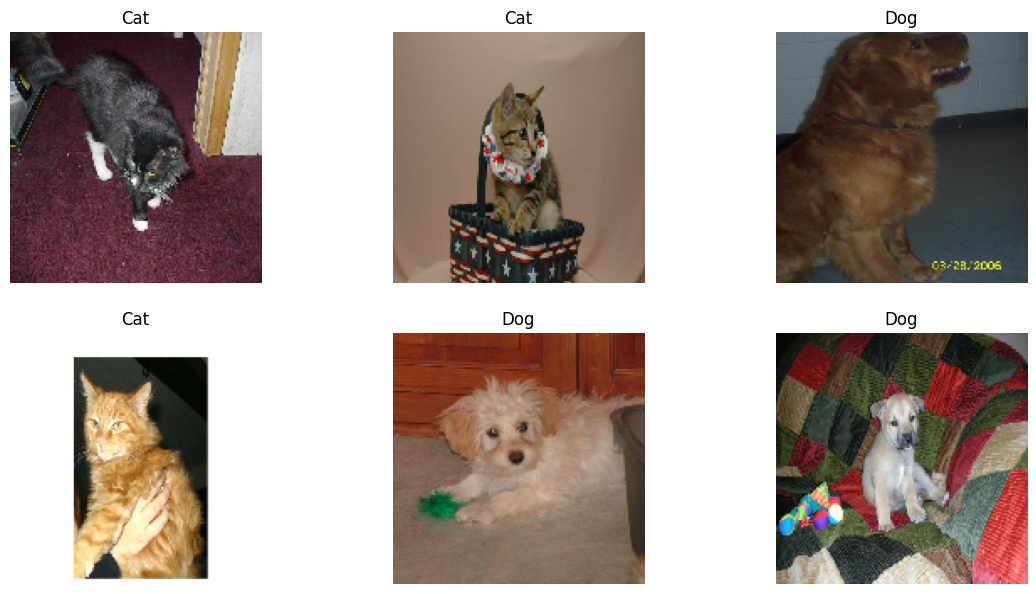

In [12]:
plot_data(train_generator,7)

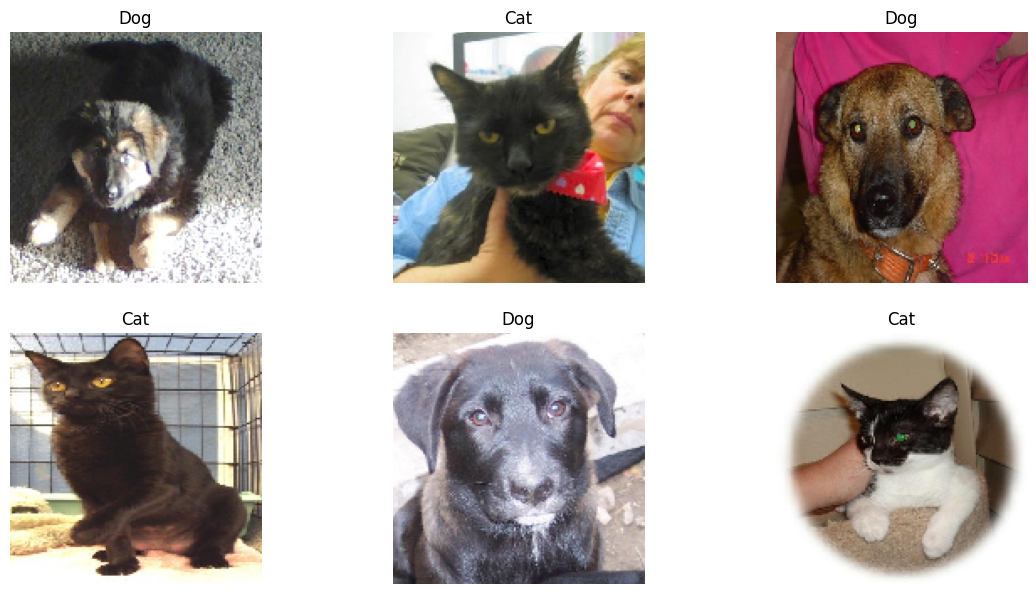

In [13]:
plot_data(validation_generator,7)

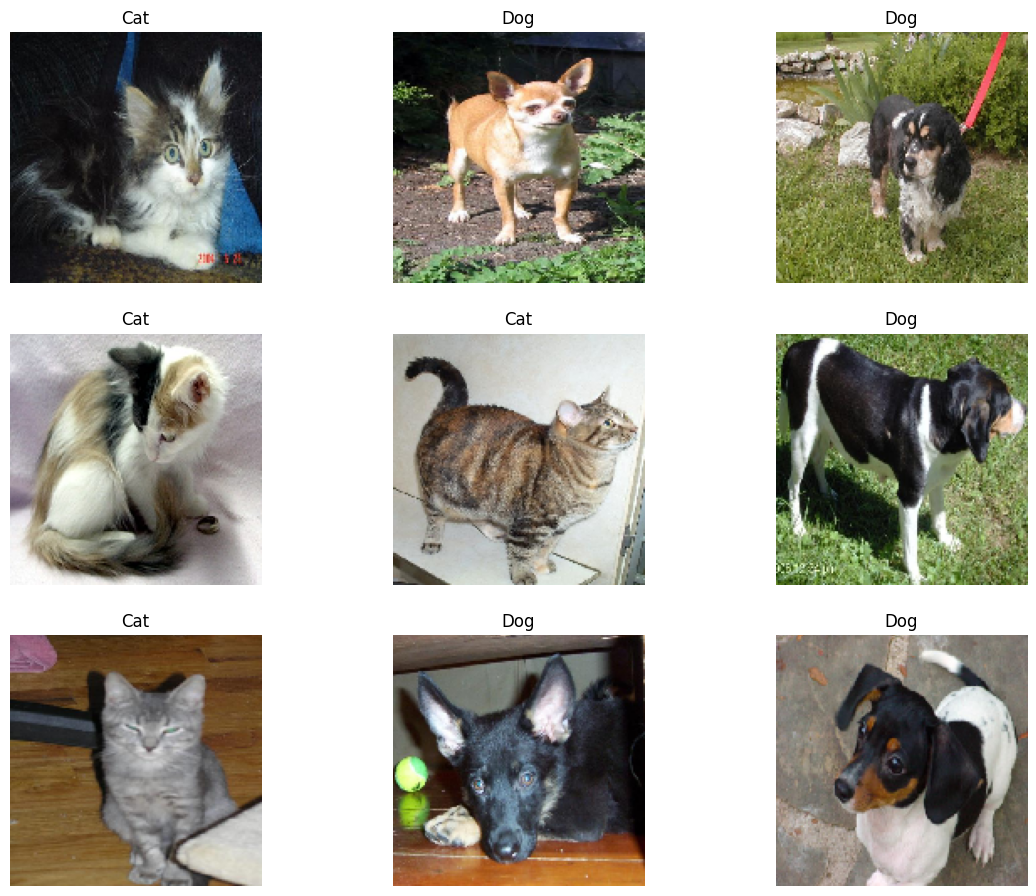

In [14]:
if INCLUDE_TEST:
    plot_data(test_generator, 10)

# MODELO

# 🧠 Definición del modelo de red neuronal convolucional (CNN) para clasificación binaria (gatos vs perros)

---

## 📌 ¿Qué hace este código?

- Define la arquitectura de un modelo CNN usando **Keras Functional API**.
- El modelo toma imágenes de tamaño `150x150x3` (RGB) y predice si es un gato o un perro.
- Utiliza varias capas **convolucionales** para extraer características, seguidas de capas **densas** para la clasificación.
- La salida es una capa `softmax` de **2 neuronas** (una para cada clase).

---

## 🤔 ¿Por qué se hace así?

- Las **capas convolucionales (`Conv2D`)** permiten extraer **patrones espaciales** de las imágenes.
- Las **capas de pooling (`MaxPooling2D`)** reducen la dimensionalidad y ayudan a evitar el sobreajuste.
- Las **capas densas (`Dense`)** al final permiten combinar las características extraídas para tomar la decisión final.
- `Softmax` se usa para clasificación **multiclase** (en este caso, 2 clases: gato y perro).

---

## 🧱 Estructura del modelo

- **Entrada:**  
  `Input(shape=(150, 150, 3))`

- **Capas ocultas:**  
  `Conv2D`, `MaxPooling2D`, `GlobalAveragePooling2D`, y capas `Dense` intermedias.

- **Salida:**  
  `Dense(2, activation='softmax')`


In [15]:

inputs = tf.keras.layers.Input(shape=(150,150,3))  # Capa de entrada: imágenes RGB de 150x150 píxeles

# Capas ocultas convolucionales y de pooling para extraer características
x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs) #Detectar patrones básicos (bordes, colores, texturas).
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x) #Aumentamos a 64 filtros para extraer patrones más complejos.
x = tf.keras.layers.MaxPooling2D(2,2)(x)# Reduce la dimensión (submuestreo) conservando la info más importante.
#Aquí divide la imagen en regiones 2x2 y toma el valor máximo de cada una.


# Segundo bloque convolucional
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)# Otra capa para aprender características más profundas.
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x) #Aumenta a 128 filtros para patrones más complejos aún.
x = tf.keras.layers.MaxPooling2D(2,2)(x) #Otra reducción del tamaño de imagen para concentrar los datos.

#Tercer bloque convolucional
#Este bloque busca patrones muy específicos y abstractos, usando 128 y 256 filtros.
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)


#En lugar de aplanar toda la imagen, toma el promedio global de cada mapa de activación.
#Reduce drásticamente la cantidad de parámetros y mejora la generalización.
#Ideal para evitar el sobreajuste.
x = tf.keras.layers.GlobalAveragePooling2D()(x)  

#Capa densa (fully connected) con 1024 neuronas.
#Función relu para activar combinaciones útiles de características detectadas.
#Actúa como "razonamiento" antes de la clasificación final.
x = Dense(1024, activation='relu')(x)

# Capa de salida: 2 neuronas (gato, perro) con softmax para obtener probabilidades
x = tf.keras.layers.Dense(2, activation='softmax')(x)

# Definición del modelo final
model = Model(inputs=inputs, outputs=x)

# Resumen de capas:
# Entrada: Input(shape=(150,150,3))
# Ocultas: Todas las Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense(1024)
# Salida: Dense(2, activation='softmax')

In [16]:
# Compila el modelo antes de entrenarlo.
# Esto configura el proceso de aprendizaje, definiendo el optimizador, la función de pérdida y las métricas a monitorear.

model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),  # Optimizador RMSprop con tasa de aprendizaje 0.001.
    # RMSprop es adecuado para problemas de visión y suele converger rápido en CNNs.
    
    loss='sparse_categorical_crossentropy',  # Función de pérdida para clasificación multiclase con etiquetas enteras.
    # En este caso, aunque hay solo dos clases, la salida es softmax (2 neuronas), así que se usa sparse_categorical_crossentropy.
    # Si las etiquetas estuvieran codificadas como one-hot, se usaría categorical_crossentropy.
    
    metrics=['accuracy']  # Métrica a monitorear durante el entrenamiento y validación.
    # 'accuracy' mide el porcentaje de predicciones correctas.
)

### importante si queremos que mejore el modelo podemos aumentar las epocas pero eso elevara el consumo computacional

In [17]:
# Entrena el modelo usando los datos de entrenamiento y valida con el conjunto de validación.
# - train_generator: generador que proporciona lotes de imágenes y etiquetas para entrenamiento.
# - epochs=10: número de veces que el modelo verá todo el conjunto de entrenamiento.
# - validation_data=validation_generator: generador para evaluar el desempeño en datos no vistos durante el entrenamiento.

r = model.fit(
        train_generator,
        epochs=10,  # Entrenar por más épocas puede mejorar los resultados
        validation_data=validation_generator  # Validación en cada época
)

Epoch 1/10
 78/387 [=====>........................] - ETA: 59:21 - loss: 0.6939 - accuracy: 0.4992

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning:

Truncated File Read



387/387 [==============================] - 4909s 13s/step - loss: 0.6788 - accuracy: 0.5586 - val_loss: 0.6352 - val_accuracy: 0.6344
Epoch 2/10
387/387 [==============================] - 995s 3s/step - loss: 0.6346 - accuracy: 0.6354 - val_loss: 0.6400 - val_accuracy: 0.6442
Epoch 3/10
387/387 [==============================] - 1037s 3s/step - loss: 0.6035 - accuracy: 0.6755 - val_loss: 0.5671 - val_accuracy: 0.7075
Epoch 4/10
387/387 [==============================] - 991s 3s/step - loss: 0.5800 - accuracy: 0.6981 - val_loss: 0.5896 - val_accuracy: 0.6928
Epoch 5/10
387/387 [==============================] - 988s 3s/step - loss: 0.5620 - accuracy: 0.7141 - val_loss: 0.5448 - val_accuracy: 0.7185
Epoch 6/10
387/387 [==============================] - 988s 3s/step - loss: 0.5489 - accuracy: 0.7255 - val_loss: 0.5245 - val_accuracy: 0.7483
Epoch 7/10
387/387 [==============================] - 1152s 3s/step - loss: 0.5374 - accuracy: 0.7316 - val_loss: 0.5076 - val_accuracy: 0.7630
Epoch 

# Evaluation

## Evaluate the model on the test set

In [18]:
# Evalúa el modelo en el conjunto de test si está habilitado.
# Esto calcula la pérdida y la precisión en datos no vistos durante el entrenamiento.
if INCLUDE_TEST:
    model.evaluate(test_generator)

39/39 [==============================] - 534s 14s/step - loss: 0.4392 - accuracy: 0.8078


## Visualize the predicitons

In [19]:
def plot_prediction(generator, n_images):
    """
    Muestra imágenes aleatorias del generador junto con la predicción del modelo y la etiqueta real.
    Si la predicción es correcta, el título es verde; si es incorrecta, es rojo.

    Parámetros:
    -----------
    generator : DirectoryIterator
        Generador de imágenes (por ejemplo, generado por flow_from_directory).
    n_images : int
        Número de imágenes a mostrar.
    """

    i = 1  # Inicializa el contador de subplots

    # Obtiene un lote de imágenes y etiquetas del generador
    images, labels = generator.next()

    # Obtiene las predicciones del modelo para las imágenes
    preds = model.predict(images)

    # Convierte las predicciones a la clase con mayor probabilidad
    predictions = np.argmax(preds, axis=1)

    # Convierte las etiquetas a enteros
    labels = labels.astype('int32')

    # Crea una figura de tamaño 14x15 pulgadas
    plt.figure(figsize=(14, 15))

    # Itera sobre las imágenes y etiquetas del lote
    for image, label in zip(images, labels):
        plt.subplot(4, 3, i)  # Crea un subplot en una cuadrícula de 4x3
        plt.imshow(image)      # Muestra la imagen

        # Si la predicción es correcta, el título es verde; si no, es rojo
        if predictions[i] == labels[i]:
            title_obj = plt.title(class_names[label])  # Título con el nombre de la clase real
            plt.setp(title_obj, color='g')             # Color verde para acierto
            plt.axis('off')                            # Oculta los ejes
        else:
            title_obj = plt.title(class_names[label])  # Título con el nombre de la clase real
            plt.setp(title_obj, color='r')             # Color rojo para error
            plt.axis('off')                            # Oculta los ejes

        i += 1  # Incrementa el contador de subplots

        # Si se han mostrado n_images imágenes, termina el bucle
        if i == n_images:
            break

    # Muestra la figura con las imágenes
    plt.show()

2/2 [==============================] - 0s 216ms/step


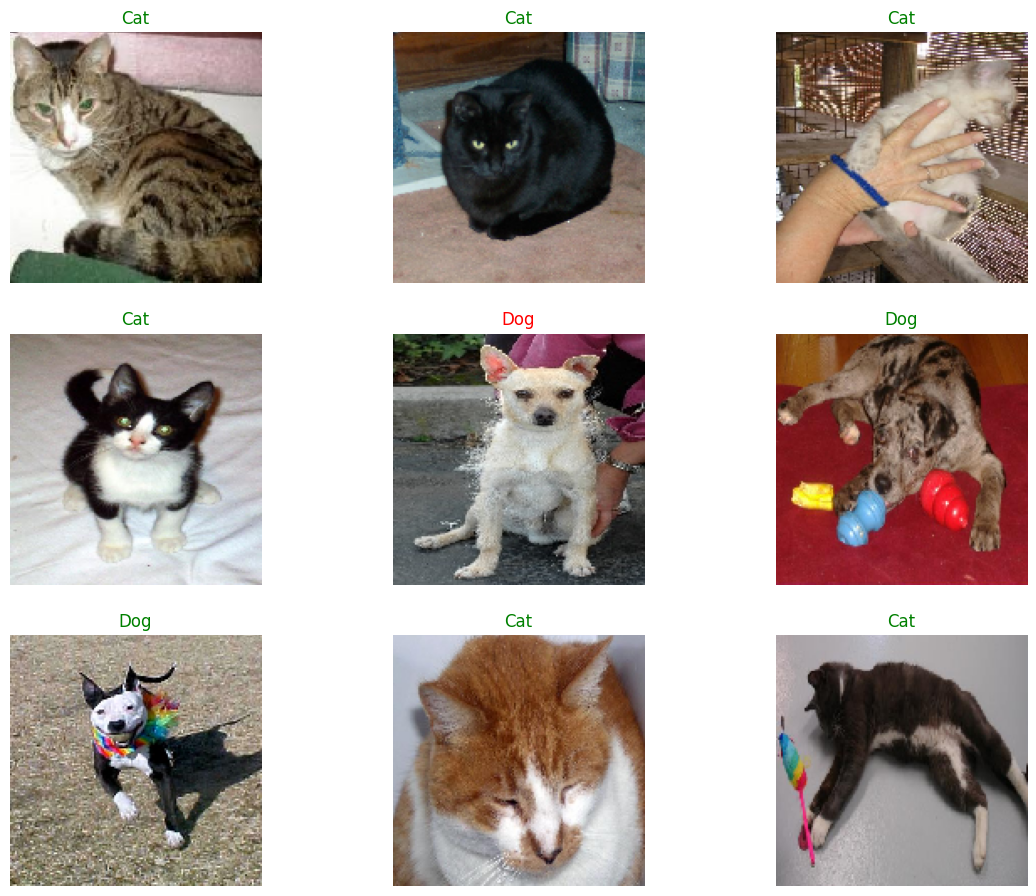

In [20]:
# Si está habilitado el conjunto de test, muestra 10 imágenes del test set con su predicción y etiqueta real.
# El título será verde si la predicción es correcta, rojo si es incorrecta.
if INCLUDE_TEST:
    plot_prediction(test_generator, 10)

2/2 [==============================] - 0s 226ms/step


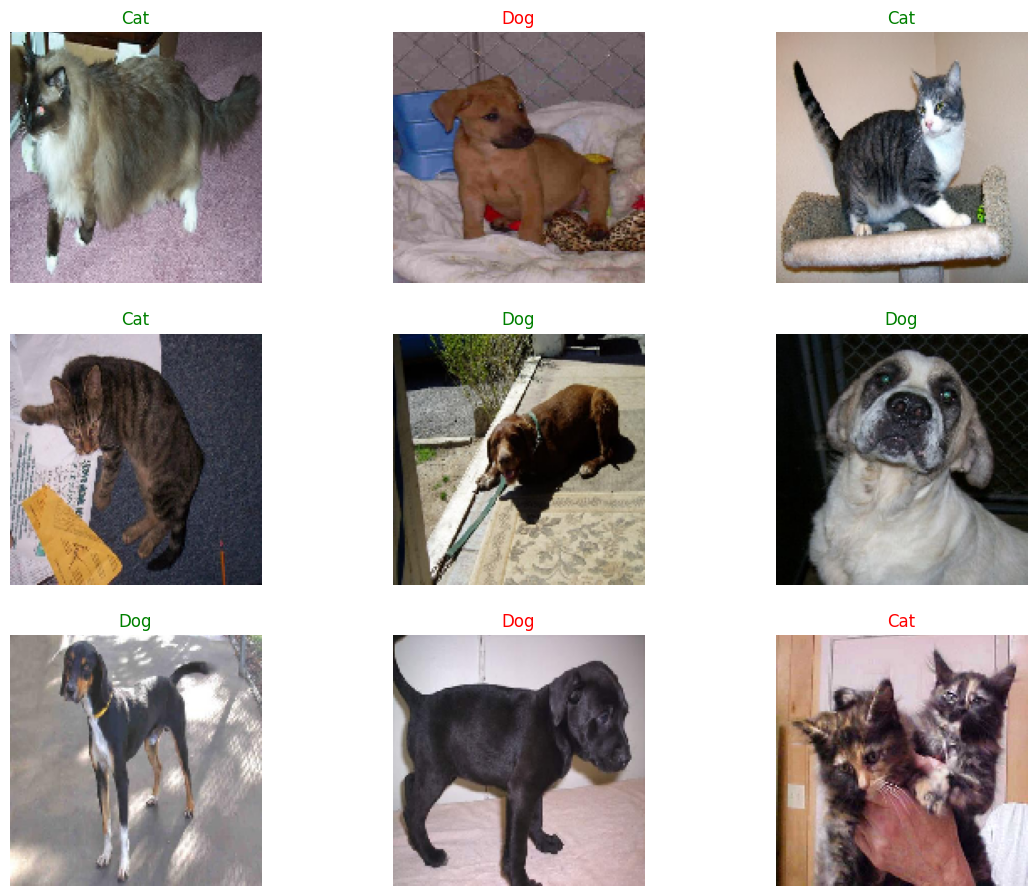

In [21]:
# Muestra 10 imágenes del conjunto de validación junto con la predicción del modelo y la etiqueta real.
# El título será verde si la predicción es correcta y rojo si es incorrecta.
plot_prediction(validation_generator, 10)

# Visualize class activation maps

In [22]:
# Obtiene los pesos de la capa densa (fully connected) antes de la salida.
# Estos pesos se usan para calcular los mapas de activación de clase (CAM).
gp_weights = model.get_layer('dense').get_weights()[0]

# Crea un modelo intermedio que toma la misma entrada que el modelo original,
# pero su salida son las activaciones de la última capa convolucional ('conv2d_5')
# y la capa densa de salida ('dense_1'). Esto permite visualizar los mapas de activación.
activation_model = Model(model.inputs, outputs=(model.get_layer('conv2d_5').output, model.get_layer('dense_1').output))

In [23]:
# Usa el modelo para hacer predicciones sobre un lote del generador de test
images, _ = test_generator.next()  # Obtiene un lote de imágenes del conjunto de test
features, results = activation_model.predict(images)  # Extrae las activaciones de la última capa convolucional y las predicciones del modelo para esas imágenes

2/2 [==============================] - 0s 221ms/step


In [24]:
def show_cam(image_index, features, results):
    """
    Visualiza el mapa de activación de clase (Class Activation Map, CAM) para una imagen específica.

    Parámetros:
    -----------
    image_index : int
        Índice de la imagen a visualizar dentro del lote de imágenes.
    features : np.ndarray
        Activaciones extraídas de la última capa convolucional para el lote de imágenes.
    results : np.ndarray
        Predicciones del modelo para el lote de imágenes.

    Qué hace:
    ---------
    - Calcula el mapa de activación de clase (CAM) para la imagen seleccionada.
    - Superpone el CAM sobre la imagen original para visualizar qué regiones influyeron más en la predicción.
    - El color del mapa depende de la confianza de la predicción.
    """

    # Extrae las características (activaciones) de la imagen seleccionada
    features_for_img = features[image_index,:,:,:]

    # Obtiene la clase predicha (índice de la clase con mayor probabilidad)
    prediction = np.argmax(results[image_index])

    # Obtiene los pesos de la capa densa para la clase predicha
    class_activation_weights = gp_weights[:,prediction]

    # Redimensiona (upsample) las activaciones al tamaño original de la imagen (150x150)
    class_activation_features = sp.ndimage.zoom(features_for_img, (150/30, 150/30, 1), order=2)

    # Calcula el mapa de activación de clase (CAM) como combinación lineal de las activaciones y los pesos
    cam_output  = np.dot(class_activation_features, class_activation_weights)

    # Imprime la clase predicha y la probabilidad asociada
    print('Predicted Class = ' + str(class_names[prediction]) + ', Probability = ' + str(results[image_index][prediction]))

    # Muestra la imagen original
    plt.imshow(images[image_index])

    # Selecciona el color del mapa: verde si la confianza es alta (>95%), azul si no
    if results[image_index][prediction] > 0.95:
        cmap_str = 'Greens'
    else:
        cmap_str = 'Blues'

    # Superpone el mapa de activación sobre la imagen original
    plt.imshow(cam_output, cmap=cmap_str, alpha=0.5)

    # Muestra la figura final
    plt.show()

In [25]:
def show_maps(desired_class, num_maps):
    """
    Recorre las primeras 10,000 imágenes de test y genera mapas de activación CAM para una clase específica.

    Parámetros:
    -----------
    desired_class : int
        Índice de la clase para la cual se mostrarán los mapas de activación (por ejemplo, 0 para 'Cat', 1 para 'Dog').
    num_maps : int
        Número de mapas de activación CAM que se desean mostrar.

    Qué hace:
    ---------
    - Itera sobre las primeras 10,000 predicciones del conjunto de test.
    - Para cada imagen, si la clase predicha coincide con `desired_class`, muestra el mapa de activación usando `show_cam`.
    - Se detiene cuando ha mostrado la cantidad de mapas especificada por `num_maps`.

    Ejemplo de uso:
    ---------------
    show_maps(desired_class=1, num_maps=5)  # Muestra 5 mapas CAM para imágenes clasificadas como 'Dog'
    """
    counter = 0
    # Recorre las primeras 10,000 imágenes
    for i in range(0, 10000):
        # Detiene si ya se mostraron los mapas requeridos
        if counter == num_maps:
            break

        # Muestra solo imágenes cuya predicción coincide con la clase deseada
        if np.argmax(results[i]) == desired_class:
            counter += 1
            show_cam(i, features, results)

Predicted Class = Dog, Probability = 0.78320557


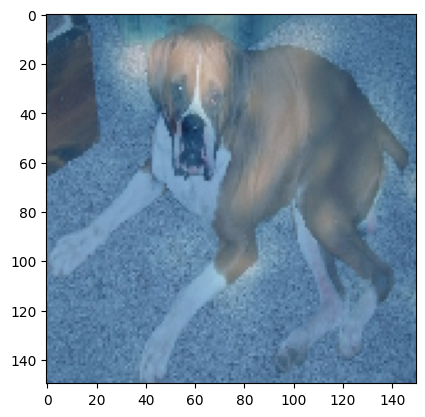

Predicted Class = Dog, Probability = 0.8244243


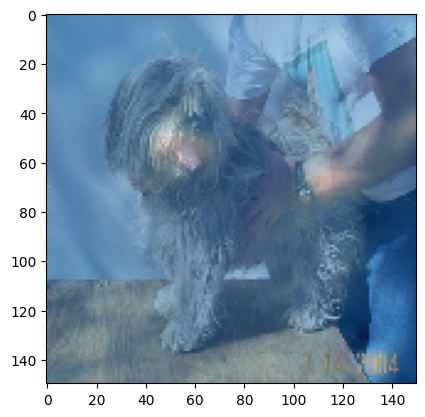

Predicted Class = Dog, Probability = 0.88127935


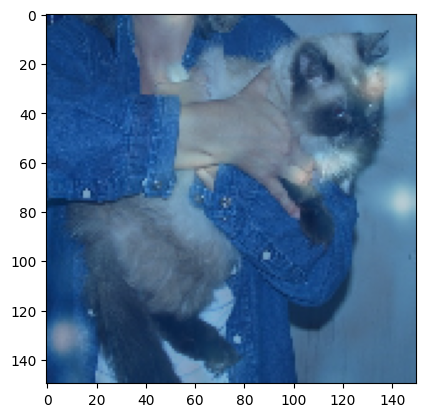

Predicted Class = Dog, Probability = 0.7791585


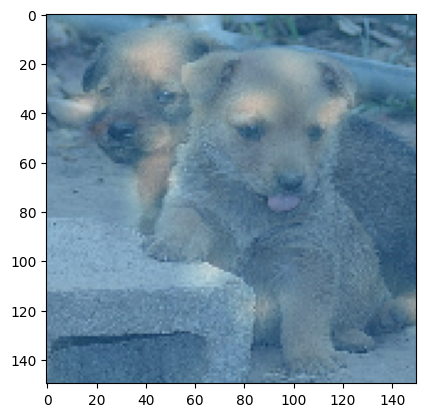

Predicted Class = Dog, Probability = 0.87467414


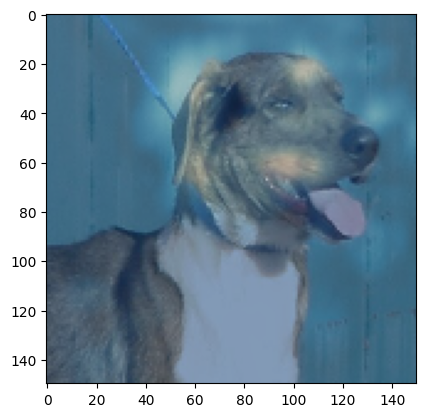

In [26]:
#desired_class=1
show_maps(desired_class=1, num_maps=5)

Predicted Class = Cat, Probability = 0.80969566


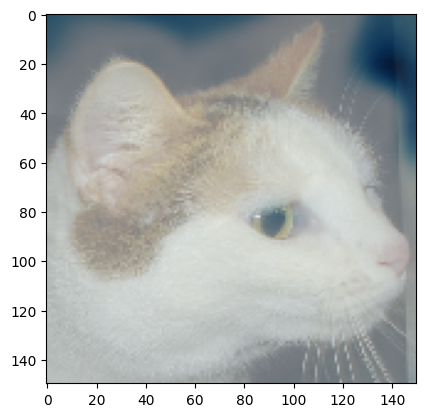

Predicted Class = Cat, Probability = 0.7770132


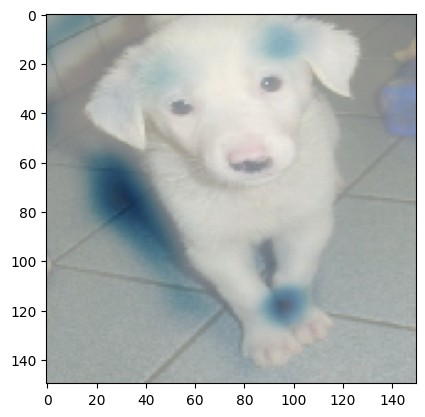

Predicted Class = Cat, Probability = 0.52369756


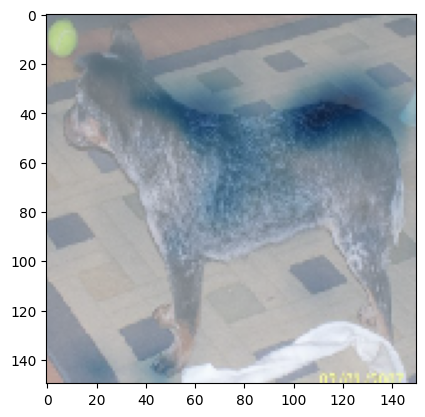

Predicted Class = Cat, Probability = 0.71151686


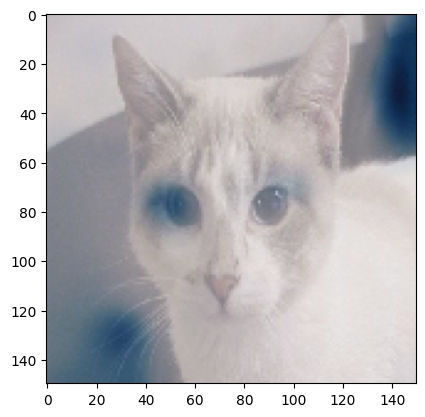

Predicted Class = Cat, Probability = 0.9348183


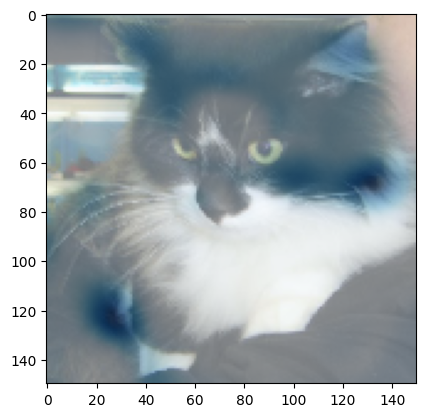

In [27]:
#gatos desired_class=0 
show_maps(desired_class=0, num_maps=5)

## Visualize training process

In [28]:
#nota se entreno solo con 1 epoca 
results = pd.DataFrame(r.history)
results.tail()

loss  accuracy  val_loss  val_accuracy
5  0.548900  0.725495  0.524498      0.748266
6  0.537388  0.731596  0.507577      0.762954
7  0.522072  0.745535  0.515152      0.746634
8  0.510442  0.755354  0.469957      0.787434
9  0.489160  0.767111  0.445161      0.792738

## 📊 Resultados de la Red Neuronal (Gatos vs Perros)

| Métrica       | Valor     | Significado                                                                 |
|---------------|-----------|------------------------------------------------------------------------------|
| `loss`        | 0.560     | Pérdida en entrenamiento. Mide el error: cuanto más bajo, mejor.            |
| `accuracy`    | 0.719     | Precisión en entrenamiento. Aciertos en el conjunto de entrenamiento.        |
| `val_loss`    | 0.534     | Pérdida en validación. Error en datos no vistos durante el entrenamiento.    |
| `val_accuracy`| 0.739     | Precisión en validación. Aciertos en imágenes nuevas.                        |

---

## ✅ Conclusiones

- **Buen desempeño inicial**  
  El modelo tiene una precisión del **71.9%** en entrenamiento y **73.9%** en validación, lo que es bastante aceptable para una primera iteración con 10 épocas.

- **No hay sobreajuste**  
  Como `val_loss < loss` y `val_accuracy > accuracy`, el modelo **generaliza bien**: no memorizó los datos de entrenamiento, sino que aprendió patrones útiles.

- **Posible mejora futura**  
  Puedes seguir mejorando el modelo:
  - Entrenando por más épocas.
  - Usando técnicas como `Dropout`, `BatchNormalization`, o **más aumentación de datos**.
  - Probando otros optimizadores o ajustando la tasa de aprendizaje (`learning_rate`).

---

## 🚀 Recomendaciones

- **Graficar curvas de entrenamiento**  
  Es útil ver cómo evolucionan `loss` y `accuracy` con las épocas para detectar posibles problemas.

- **Probar modelos preentrenados**  
  Usar modelos como `VGG16`, `MobileNet`, `ResNet`, etc., puede mejorar el rendimiento con menos datos.

- **Revisar balance de clases**  
  Asegúrate de que haya una cantidad equilibrada de imágenes de gatos y perros para evitar sesgos.

¿Quieres que incluya las gráficas o un ejemplo para predecir nuevas imágenes?


In [29]:
fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(   
    title_font_color="#fad25a", 
    xaxis=dict(color="#fad25a",title='Epochs'), 
    yaxis=dict(color="#fad25a")
 )
fig.show()

In [30]:
fig = px.line(results,y=[results['loss'],results['val_loss']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(   
    title_font_color="#fad25a", 
    xaxis=dict(color="#fad25a",title='Epochs'), 
    yaxis=dict(color="#fad25a")
 )
fig.show()

# 🧪 Trying Data Augmentation

## ¿Qué es la Aumentación de Datos?

La **data augmentation** es una técnica usada para **aumentar artificialmente el tamaño del dataset** mediante la creación de versiones modificadas de las imágenes originales. Esto ayuda al modelo a **generalizar mejor** y a evitar el **sobreajuste (overfitting)**.

---

## 🛠️ Técnicas comunes de aumentación

- **Rotación aleatoria** (`rotation_range`)
- **Zoom aleatorio** (`zoom_range`)
- **Volteo horizontal** (`horizontal_flip`)
- **Cambio de brillo/contraste**
- **Desplazamientos horizontales y verticales** (`width_shift_range`, `height_shift_range`)
- **Recortes aleatorios**

## 🎯 ¿Por qué usar Data Augmentation?

- 🚫 **Evita el sobreajuste (overfitting)**: el modelo no memoriza los datos, aprende a generalizar.
- 📈 **Simula un dataset más grande y variado**: permite entrenar con más ejemplos sin recolectar nuevas imágenes.
- 🧠 **Hace que el modelo sea más robusto**: se adapta mejor a variaciones reales en las imágenes (ángulos, tamaños, posiciones).
---

## 📦 Ejemplo en Keras usando `ImageDataGenerator`

```python
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,       # Rotación aleatoria
    zoom_range=0.2,          # Zoom aleatorio
    horizontal_flip=True,    # Volteo horizontal
    width_shift_range=0.1,   # Desplazamiento horizontal
    height_shift_range=0.1   # Desplazamiento vertical
)



In [31]:
train_gen_aug = ImageDataGenerator(
        rescale=1./255,fill_mode='nearest',horizontal_flip=True,
        rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
)


validation_gen_aug =  ImageDataGenerator(
        rescale=1./255.)

In [32]:
train_generator = train_gen_aug.flow_from_directory(
        'cats-vs-dogs/training',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')
validation_generator = validation_gen_aug.flow_from_directory(
        'cats-vs-dogs/validation',
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

Found 24750 images belonging to 2 classes.
Found 2451 images belonging to 2 classes.


In [33]:
inputs = tf.keras.layers.Input(shape=(150,150,3))
x =  tf.keras.layers.Conv2D(32, (3,3), activation='relu')(inputs)
x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)

x = tf.keras.layers.Conv2D(128, (3,3), activation='relu')(x)
x = tf.keras.layers.Conv2D(256, (3,3), activation='relu')(x)
x = tf.keras.layers.MaxPooling2D(2,2)(x)


x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x) 
x = tf.keras.layers.Dense(2, activation='softmax')(x) 

model_aug = Model(inputs=inputs, outputs=x)

In [34]:
model_aug.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics = ['accuracy'])

In [35]:
r = model_aug.fit(
        train_generator,
        epochs=1,#Training longer could yield better results
        validation_data=validation_generator)

301/774 [==========>...................] - ETA: 16:35 - loss: 0.7223 - accuracy: 0.4988

c:\Users\ASUS\AppData\Local\Programs\Python\Python310\lib\site-packages\PIL\TiffImagePlugin.py:950: UserWarning:

Truncated File Read



774/774 [==============================] - 1641s 2s/step - loss: 0.7024 - accuracy: 0.5307 - val_loss: 0.6674 - val_accuracy: 0.6055


In [36]:
results = pd.DataFrame(r.history)
results.tail()

loss  accuracy  val_loss  val_accuracy
0  0.702378  0.530707  0.667366      0.605467

In [37]:
fig = px.line(results,y=[results['accuracy'],results['val_accuracy']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(   
    title_font_color="#fad25a", 
    xaxis=dict(color="#fad25a",title='Epochs'), 
    yaxis=dict(color="#fad25a")
 )
fig.show()

In [38]:
fig = px.line(results,y=[results['loss'],results['val_loss']],template="seaborn",color_discrete_sequence=['#fad25a','red'])
fig.update_layout(   
    title_font_color="#fad25a", 
    xaxis=dict(color="#fad25a",title='Epochs'), 
    yaxis=dict(color="#fad25a")
 )
fig.show()

## 📌 Conclusiones

- Usar **data augmentation** con estos hiperparámetros nos dio **peores resultados**.
- Podemos intentar usar **transfer learning** o una **arquitectura más compleja** para mejorar el desempeño del modelo.
- Estos temas los discutiremos en notebooks posteriores.